In [1]:
from casadi import *
import numpy as np

d = 3
tau_root = [0] + collocation_points(d, "legendre")

C = np.zeros((d+1,d+1))
D = np.zeros(d+1)
B = np.zeros(d+1)
tau = SX.sym("tau")

for j in range(d+1):
# Construct Lagrange polynomials to get the polynomial basis at the collocation point
    L = 1
    for r in range(d+1):
        if r != j:
            L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])


    lfcn = Function('lfcn', [tau],[L])
    D[j] = lfcn(1.0)

    tfcn = Function('tfcn', [tau],[tangent(L,tau)])
    for r in range(d+1):
        C[j,r] = tfcn(tau_root[r])

    ###% Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    L= np.poly1d([L])
    pint = np.polyint(L)
    B[j] = pint(1.0)


T = MX.sym('T')

x1 = SX.sym('x1')
x2 = SX.sym('x2')
x3 = SX.sym('x3')
x = vertcat(x1, x2, x3)
u = SX.sym('u')
xdot = ca.vertcat((1-x2**2)*x1 - x2 + u, x1)


L = x1**2 + x2**2 + u**2
f = Function('f', [x, u], [xdot, L], ['x', 'u'], ['xdot', 'L'])


N = 59
h = T/N


w=[]
w0 = []
lbw = []
ubw = []
g=[]
lbg = []
ubg = []

x_plot = []
u_plot = []

m0 = 214.839
mf = 67.9833
Fm = 9.525515


Xk = MX.sym('X0', 2)
w.append(Xk)
lbw.append([0, 1])
ubw.append([0, 1])
w0.append([0, 1])
x_plot.append(Xk)


# Formulate the NLP
for k in range(N):
    # New NLP variable for the control
    Uk = ca.MX.sym('U_' + str(k))
    w.append(Uk)
    lbw.append([-1])
    ubw.append([1])
    w0.append([0])
    u_plot.append(Uk)

    # State at collocation points
    Xc = []
    for j in range(d):
        Xkj = ca.MX.sym('X_'+str(k)+'_'+str(j), 2)
        Xc.append(Xkj)
        w.append(Xkj)
        lbw.append([-0.25, -np.inf])
        ubw.append([np.inf,  np.inf])
        w0.append([0, 0])

    # Loop over collocation points
    Xk_end = D[0]*Xk
    for j in range(1,d+1):
       # Expression for the state derivative at the collocation point
       xp = C[0,j]*Xk
       for r in range(d): xp = xp + C[r+1,j]*Xc[r]

       # Append collocation equations

       fj, qj = f(Xc[j-1],Uk)
       g.append(h*fj - xp)
       lbg.append([0, 0])
       ubg.append([0, 0])

       # Add contribution to the end state
       Xk_end = Xk_end + D[j]*Xc[j-1]

       # Add contribution to quadrature function
       J = J + B[j]*qj*h

    # New NLP variable for state at end of interval
    Xk = ca.MX.sym('X_' + str(k+1), 2)
    w.append(Xk)
    lbw.append([-0.25, -np.inf])
    ubw.append([np.inf,  np.inf])
    w0.append([0, 0])
    x_plot.append(Xk)

    # Add equality constraint
    g.append(Xk_end-Xk)
    lbg.append([0, 0])
    ubg.append([0, 0])


# Create an NLP solver
prob = {'f': J, 'x': w, 'g': g}
solver = ca.nlpsol('solver', 'ipopt', prob);

# Function to get x and u trajectories from w
trajectories = ca.Function('trajectories', [w], [x_plot, u_plot], ['w'], ['x', 'u'])

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
x_opt, u_opt = trajectories(sol['x'])
x_opt = x_opt.full() # to numpy array
u_opt = u_opt.full() # to numpy array

# Plot the result
tgrid = np.linspace(0, T, N+1)
plt.figure(1)
plt.clf()
plt.plot(tgrid, x_opt[0], '--')
plt.plot(tgrid, x_opt[1], '-')
plt.step(tgrid, np.append(np.nan, u_opt[0]), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()

Exception: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:      549
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      175
                     variables with only upper bounds:        0
Total number of equality constraints.................:      504
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 201

   

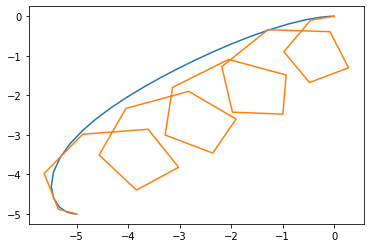

In [2]:
""" orthogonal collocation with 4 states for the positing of a vessel """

# general libraries
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# %% specify the problem

# Declare model variables
rtf = ca.SX.sym('rtf')  # real time factor
x1 = ca.SX.sym('x1')  # N
x2 = ca.SX.sym('x2')  # E
x3 = ca.SX.sym('x3')  # heading
x4 = ca.SX.sym('x4')  # forward speed
u1 = ca.SX.sym('u1')  # a_u (acceleration in surge)
u2 = ca.SX.sym('u2')  # a_psi (rate of turn)

u = ca.vertcat(u1, u2)
x = ca.vertcat(x1, x2, x3, x4)
n_controls = np.prod(u.shape)
n_states = np.prod(x.shape)

# Model equations
xdot = ca.vertcat((x4 * ca.cos(x3)) * rtf,
                  (x4 * ca.sin(x3)) * rtf,
                  (x4**2 * u2) * rtf,
                  (u1) * rtf)

# Objective term
L = (u1**2 + x4**4 * u2**2 + 1) * rtf

# Continuous time dynamics
f = ca.Function('f', [x, rtf, u], [xdot, L], ['x', 'rtf', 'u'], ['xdot', 'L'])

# Constraints (constant bounds, more complex should be in formulation of NLP)
lrtf = 0
urtf = 100
xlb = [-ca.inf, -ca.inf, -ca.inf, 0]
xub = [ca.inf, ca.inf, ca.inf, 1]
ulb = [-1, -10]
uub = [1, 10]

# Initial/final state
X0 =  [-5, -5, -3*np.pi, 0.0]
XF =  [0, 0, 0*np.pi, 0]

# Initial guess at each time point
x_guess = [0, 0, X0[2], 0]

# %% setup the collocation
T = 1.0  # time horizon
d = 4    # degree of interpolating polynomial
N = 25   # number of control intervals
h = T/N  # Control discretization

# Get collocation points
tau_root = np.append(0, ca.collocation_points(d, 'legendre'))

# Coefficients of the collocation equation
C = np.zeros((d+1, d+1))

# Coefficients of the continuity equation
D = np.zeros(d+1)

# Coefficients of the quadrature function
B = np.zeros(d+1)

# Construct polynomial basis
P = []
for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
    p = np.poly1d([1])
    for r in range(d+1):
        if r != j:
            p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])
    P.append(p)

    # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    D[j] = p(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    pder = np.polyder(p)
    for r in range(d+1):
        C[j,r] = pder(tau_root[r])

    # Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    pint = np.polyint(p)
    B[j] = pint(1.0)

# %% setup the NLP

# the intitial and final state are set as constraint in the complex plane
heading_cpx = ca.vertcat(ca.sin(x3), ca.cos(x3))
f_heading = ca.Function('heading2complex', [x], [heading_cpx], ['x'], ['hdg_cpx'])
psi0 = X0[2]
psiF = XF[2]

# helper (zeros for the state constraints)
z_x = [0]*n_states
z_u = [0]*n_controls

# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

# extract collocation points for state plotting, and the control signals
x_c = []  # all the collocation points for interpolation
x_knot = []  # only at the discrete knot points
u_knot = []

# add the real time factor as a 'parameter'
p = ca.MX.sym('p', 1)
w.append(p)
lbw.append([lrtf])
ubw.append([urtf])
w0.append([(urtf + lrtf) / 2.0])

# "Lift" initial conditions
Xk = ca.MX.sym('X0', n_states)
w.append(Xk)
lbw.append(X0.copy())
lbw[-1][2] = -ca.inf  # remove the state constraint
ubw.append(X0.copy())
ubw[-1][2] = ca.inf  # remove the state constraint
w0.append(X0.copy())
x_knot.append(Xk)
x_c.append(Xk)

# add the heading constraint
g.append(f_heading(Xk))
lbg.append([ca.sin(psi0), ca.cos(psi0)])
ubg.append([ca.sin(psi0), ca.cos(psi0)])

# Formulate the NLP
for k in range(N):

    # New NLP variable for the control
    Uk = ca.MX.sym('U_' + str(k), n_controls)
    w.append(Uk)
    lbw.append(ulb)
    ubw.append(uub)
    w0.append(z_u)
    u_knot.append(Uk)

    # State at collocation points
    Xc = []
    for j in range(d):
        Xkj = ca.MX.sym('X_'+str(k)+'_'+str(j), n_states)
        Xc.append(Xkj)
        x_c.append(Xkj)
        w.append(Xkj)
        lbw.append(xlb)
        ubw.append(xub)
        w0.append(x_guess)

    # Loop over collocation points
    Xk_end = D[0]*Xk
    for j in range(1,d+1):

        # Expression for the state derivative at the collocation point
        xp = C[0,j]*Xk
        for r in range(d): xp = xp + C[r+1,j]*Xc[r]

        # Append collocation equations --> added the p here
        fj, qj = f(Xc[j-1], p, Uk)
        g.append(h*fj - xp)
        lbg.append(z_x)
        ubg.append(z_x)

        # Add contribution to the end state
        Xk_end = Xk_end + D[j]*Xc[j-1];

        # Add contribution to quadrature function
        J = J + B[j]*qj*h

    # New NLP variable for state at end of interval
    Xk = ca.MX.sym('X_' + str(k+1), n_states)
    w.append(Xk)
    lbw.append(xlb)
    ubw.append(xub)
    w0.append(x_guess)
    x_c.append(Xk)
    x_knot.append(Xk)

    # Add equality constraint
    g.append(Xk_end-Xk)
    lbg.append(z_x)
    ubg.append(z_x)

# set the final state [x, y, fie, vel]
# but set the fie to +- inf and redo afterwards in complex plane
ubw[-1] = XF.copy()
ubw[-1][2] = np.inf
lbw[-1] = XF.copy()
lbw[-1][2] = -np.inf

# but I want heading to wrap
g.append(f_heading(Xk))
lbg.append([ca.sin(psiF), ca.cos(psiF)])
ubg.append([ca.sin(psiF), ca.cos(psiF)])

# Concatenate vectors
w = ca.vertcat(*w)
g = ca.vertcat(*g)
u_knot = ca.horzcat(*u_knot)
x_knot = ca.horzcat(*x_knot)
x_c = ca.horzcat(*x_c)
w0 = np.concatenate(w0)
lbw = np.concatenate(lbw)
ubw = np.concatenate(ubw)
lbg = np.concatenate(lbg)
ubg = np.concatenate(ubg)

# Function to get x and u trajectories from w
trajectories = ca.Function('trajectories', [w], [x_c, x_knot, u_knot], ['w'], ['xc', 'xk', 'u'])

# %% Create an NLP solver and solve
prob = {'f': J, 'x': w, 'g': g}
opt ={'ipopt.print_level': 3, 'print_time' :True, 'ipopt.max_cpu_time':120.0,
      'expand': True, 'warn_initial_bounds': True}
solver = ca.nlpsol('solver', 'ipopt', prob, opt)

# go
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

# extract the 'free' variables, and convert to numpy
x_c, x_opt, u_opt = trajectories(sol['x'])
#x_c = x_c.full()
x_opt = x_opt.full()
u_opt = u_opt.full()

# to match dimensions, we add some nans to the contorl signal
u_opt = np.hstack((u_opt, np.full([n_controls, 1], np.nan)))
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
ax.plot(x_opt[0, :], x_opt[1,:])
# %%
if True:

    X0 =  [-5, 0, 2*np.pi, 0.0]
    XF =  [0, 0, 2*np.pi, 0]
    
    # in constraint g nothing changes
    
    # only initial estimate changes
    w0 = sol['x'].full()
    w0[3] = 5*np.pi
    
    
    
    opt ={'ipopt.print_level': 5, 'print_time' :True, 'ipopt.max_cpu_time':120.0,
          'expand': True, 'warn_initial_bounds': True, 'ipopt.max_iter': 110}
    solver = ca.nlpsol('solver', 'ipopt', prob, opt)
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    
    # extract the 'free' variables, and convert to numpy
    x_c, x_opt, u_opt = trajectories(sol['x'])
    x_c = x_c.full()
    x_opt = x_opt.full()
    u_opt = u_opt.full()
    
    # to match dimensions, we add some nans to the contorl signal
    u_opt = np.hstack((u_opt, np.full([n_controls, 1], np.nan)))
    
    plt.plot(x_opt[0, :], x_opt[1, :])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1192
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      268
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      184
                     variables with only upper bounds:        0
Total number of equality constraints.................:      240
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

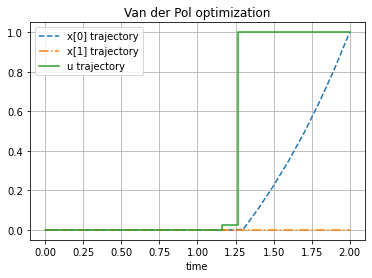

In [3]:
# -*- coding: utf-8 -*-
from casadi import *
from casadi.tools import *

import numpy as NP
import matplotlib.pyplot as plt

nk = 20    # Control discretization
tf = 2.0  # End time

# Declare variables (use scalar graph)
t  = SX.sym("t")    # time
u  = SX.sym("u")    # control

states = struct_symSX([
            entry('x',shape=2),    #  vdp oscillator states
            entry('L')             #  helper state: Langrange integrand
         ])

# Create a structure for the right hand side
rhs = struct_SX(states)
x = states['x']
rhs["x"] = vertcat((1 - x[1]*x[1])*x[0] - x[1] + u, x[0])
rhs["L"] = x[0]*x[0] + x[1]*x[1] + u*u

# ODE right hand side function
f = Function('f', [t,states,u],[rhs])

# Objective function (meyer term)
m = Function('m', [t,states,u],[states["L"]])

# Control bounds
u_min = -0.75
u_max = 1.0
u_init = 0.0

u_lb = NP.array([u_min])
u_ub = NP.array([u_max])
u_init = NP.array([u_init])

# State bounds and initial guess
# x_min =  [-inf, -inf, -inf]
# x_max =  [ inf,  inf,  inf]
# xi_min = [ 0.0,  1.0,  0.0]
# xi_max = [ 0.0,  1.0,  0.0]
# xf_min = [ 0.0,  0.0, -inf]
# xf_max = [ 0.0,  0.0,  inf]
# x_init = [ 0.0,  0.0,  0.0]

x_min  = [0.0,    0.0,        -inf]
x_max  = [1.0, 1.5, inf]
xi_min = [0.0,    0.0,         0.0]
xi_max = [0.0,    0.0,         inf]
xf_min = [1.0, 0.0,        -inf]
xf_max = [1.0, 0.0,         inf]
x_init = [0.0,    0.0,         0.0]


# Dimensions
nx = 3
nu = 1

# Choose collocation points
tau_root = [0] + collocation_points(3,"radau")

# Degree of interpolating polynomial
d = len(tau_root)-1

# Size of the finite elements
h = tf/nk

# Coefficients of the collocation equation
C = NP.zeros((d+1,d+1))

# Coefficients of the continuity equation
D = NP.zeros(d+1)

# Dimensionless time inside one control interval
tau = SX.sym("tau")

# All collocation time points
T = NP.zeros((nk,d+1))
for k in range(nk):
  for j in range(d+1):
    T[k,j] = h*(k + tau_root[j])

# For all collocation points
for j in range(d+1):
  # Construct Lagrange polynomials to get the polynomial basis at the collocation point
  L = 1
  for r in range(d+1):
    if r != j:
      L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

  # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
  lfcn = Function('lfcn', [tau],[L])
  D[j] = lfcn(1.0)

  # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
  tfcn = Function('tfcn', [tau],[tangent(L,tau)])
  for r in range(d+1):
    C[j,r] = tfcn(tau_root[r])

# Structure holding NLP variables
V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

vars_lb   = V()
vars_ub   = V()
vars_init = V()

# Set states and its bounds
vars_init["X",:,:] = repeated(repeated(x_init))
vars_lb["X",:,:]   = repeated(repeated(x_min))
vars_ub["X",:,:]   = repeated(repeated(x_max))

# Set controls and its bounds
vars_init["U",:] = repeated(u_init)
vars_lb["U",:]   = repeated(u_min)
vars_ub["U",:]   = repeated(u_max)

# State at initial time
vars_lb["X",0,0] = xi_min
vars_ub["X",0,0] = xi_max

# State at end time
vars_lb["X",-1,0] = xf_min
vars_ub["X",-1,0] = xf_max

# Constraint function for the NLP
g = []
lbg = []
ubg = []

# For all finite elements
for k in range(nk):

  # For all collocation points
  for j in range(1,d+1):

    # Get an expression for the state derivative at the collocation point
    xp_jk = 0
    for r in range (d+1):
      xp_jk += C[r,j]*V["X",k,r]

    # Add collocation equations to the NLP
    fk = f(T[k][j], V["X",k,j], V["U",k])
    g.append(h*fk - xp_jk)
    lbg.append(NP.zeros(nx)) # equality constraints
    ubg.append(NP.zeros(nx)) # equality constraints

  # Get an expression for the state at the end of the finite element
  xf_k = 0
  for r in range(d+1):
    xf_k += D[r]*V["X",k,r]

  # Add continuity equation to NLP
  g.append(V["X",k+1,0] - xf_k)
  lbg.append(NP.zeros(nx))
  ubg.append(NP.zeros(nx))

# Concatenate constraints
g = vertcat(*g)

# Objective function
f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

# NLP
nlp = {'x':V, 'f':f, 'g':g}

## ----
## SOLVE THE NLP
## ----

# Set options
opts = {}
opts["expand"] = True
#opts["ipopt.max_iter"] = 4
#opts["ipopt.linear_solver"] = 'ma27'

# Allocate an NLP solver
solver = nlpsol("solver", "ipopt", nlp, opts)
arg = {}

# Initial condition
arg["x0"] = vars_init

# Bounds on x
arg["lbx"] = vars_lb
arg["ubx"] = vars_ub

# Bounds on g
arg["lbg"] = NP.concatenate(lbg)
arg["ubg"] = NP.concatenate(ubg)

# Solve the problem
res = solver(**arg)

# Print the optimal cost
print("optimal cost: ", float(res["f"]))

# Retrieve the solution
opt = V(res["x"])

# Get values at the beginning of each finite element
x0_opt = opt["X",:,0,"x",0]
x1_opt = opt["X",:,0,"x",1]
x2_opt = opt["X",:,0,"L"]

u_opt = opt["U",:,0]

tgrid = NP.linspace(0,tf,nk+1)
tgrid_u = NP.linspace(0,tf,nk)

# Plot the results
plt.figure(1)
#plt.clf()
plt.plot(tgrid,NP.array(x0_opt).squeeze(),'--')
plt.plot(tgrid,NP.array(x1_opt).squeeze(),'-.')
plt.step(tgrid_u,NP.array(u_opt).squeeze(),'-')
plt.title("Van der Pol optimization")
plt.xlabel('time')
plt.legend(['x[0] trajectory','x[1] trajectory','u trajectory'])
plt.grid()
plt.show()

In [4]:
tgrid,NP.array(x0_opt).squeeze()

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00253362, 0.10778224,
        0.22353628, 0.35083948, 0.49083398, 0.64476712, 0.8139975 ,
        1.        ]))

Exception of type: OPTION_INVALID in file "../../../../Ipopt/src/Algorithm/IpAlgBuilder.cpp" at line 321:
 Exception message: Selected linear solver MA27 not available.
Tried to obtain MA27 from shared library "libhsl.so", but the following error occured:
libhsl.so: cannot open shared object file: No such file or directory

EXIT: Invalid option encountered.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       total  | 348.00us (348.00us) 316.08us (316.08us)         1
optimal cost:  nan


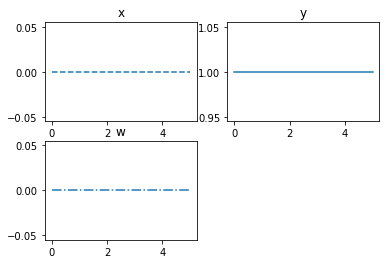

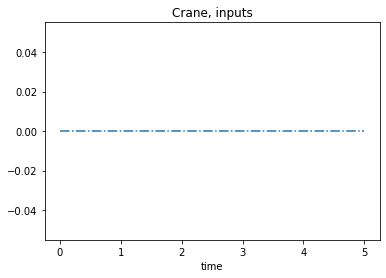

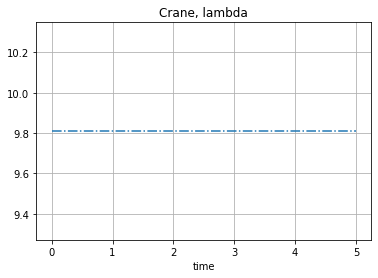

In [13]:


from casadi import *
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Collocation setup
# -----------------------------------------------------------------------------
nicp = 1        # Number of (intermediate) collocation points per control interval

xref = 0.1 # chariot reference

l = 1. #- -> crane, + -> pendulum
m = 1.
M = 1.
g = 9.81
tf = 5.0
nk = 50
ndstate = 6
nastate = 1
ninput = 1

# Degree of interpolating polynomial
deg = 4
# Radau collocation points
cp = "radau"
# Size of the finite elements
h = tf/nk/nicp

# Coefficients of the collocation equation
C = np.zeros((deg+1,deg+1))
# Coefficients of the continuity equation
D = np.zeros(deg+1)

# Collocation point
tau = SX.sym("tau")

# All collocation time points
tau_root = [0] + collocation_points(deg, cp)

T = np.zeros((nk,deg+1))
for i in range(nk):
    for j in range(deg+1):
        T[i][j] = h*(i + tau_root[j])

# For all collocation points: eq 10.4 or 10.17 in Biegler's book
# Construct Lagrange polynomials to get the polynomial basis at the collocation point
for j in range(deg+1):
    L = 1
    for j2 in range(deg+1):
        if j2 != j:
            L *= (tau-tau_root[j2])/(tau_root[j]-tau_root[j2])

    # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    lfcn = Function('lfcn', [tau],[L])
    D[j] = lfcn(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    tfcn = Function('tfcn', [tau],[tangent(L,tau)])
    for j2 in range(deg+1):
        C[j][j2] = tfcn(tau_root[j2])

# -----------------------------------------------------------------------------
# Model setup
# -----------------------------------------------------------------------------
# Declare variables (use scalar graph)
t  = SX.sym("t")          # time
u  = SX.sym("u")          # control
xd  = SX.sym("xd",ndstate)      # differential state
xa  = SX.sym("xa",nastate)    # algebraic state
xddot  = SX.sym("xdot",ndstate) # differential state time derivative
p = SX.sym("p",0,1)      # parameters

x = SX.sym("x")
y = SX.sym("y")
w = SX.sym("w")

dx = SX.sym("dx")
dy = SX.sym("dy")
dw = SX.sym("dw")


res = vertcat(xddot[0] - dx,\
       xddot[1] - dy,\
       xddot[2] - dw,\
       m*xddot[3] + (x-w)*xa, \
       m*xddot[4] +     y*xa - g*m,\
       M*xddot[5] + (w-x)*xa +   u,\
       (x-w)*(xddot[3] - xddot[5]) + y*xddot[4] + dy*dy + (dx-dw)*(dx-dw))


xd[0] = x
xd[1] = y
xd[2] = w
xd[3] = dx
xd[4] = dy
xd[5] = dw


# System dynamics (implicit formulation)
ffcn = Function('ffcn', [t,xddot,xd,xa,u,p],[res])

# Objective function
MayerTerm = Function('mayer', [t,xd,xa,u,p],[(x-xref)*(x-xref) + (w-xref)*(w-xref) + dx*dx + dy*dy])
LagrangeTerm = Function('lagrange', [t,xd,xa,u,p],[(x-xref)*(x-xref) + (w-xref)*(w-xref)])

# Control bounds
u_min = np.array([-2])
u_max = np.array([ 2])
u_init = np.array((nk*nicp*(deg+1))*[[0.0]]) # needs to be specified for every time interval (even though it stays constant)

# Differential state bounds
#Path bounds
xD_min =  np.array([-inf, -inf, -inf, -inf, -inf, -inf])
xD_max =  np.array([ inf,  inf,  inf,  inf,  inf,  inf])
#Initial bounds
xDi_min = np.array([ 0.0,  l,  0.0,  0.0,  0.0,  0.0])
xDi_max = np.array([ 0.0,  l,  0.0,  0.0,  0.0,  0.0])
#Final bounds
xDf_min = np.array([-inf, -inf, -inf, -inf, -inf, -inf])
xDf_max = np.array([ inf,  inf,  inf,  inf,  inf,  inf])

#Initial guess for differential states
xD_init = np.array((nk*nicp*(deg+1))*[[ 0.0,  l,  0.0,  0.0,  0.0,  0.0]]) # needs to be specified for every time interval

# Algebraic state bounds and initial guess
xA_min =  np.array([-inf])
xA_max =  np.array([ inf])
xAi_min = np.array([-inf])
xAi_max = np.array([ inf])
xAf_min = np.array([-inf])
xAf_max = np.array([ inf])
xA_init = np.array((nk*nicp*(deg+1))*[[sign(l)*9.81]])

# Parameter bounds and initial guess
p_min = np.array([])
p_max = np.array([])
p_init = np.array([])




# -----------------------------------------------------------------------------
# Constraints setup
# -----------------------------------------------------------------------------
# Initial constraint
ic_min = np.array([])
ic_max = np.array([])
ic = SX()
#ic.append();       ic_min = append(ic_min, 0.);         ic_max = append(ic_max, 0.)
icfcn = Function('icfcn', [t,xd,xa,u,p],[ic])
# Path constraint
pc_min = np.array([])
pc_max = np.array([])
pc = SX()
#pc.append();       pc_min = append(pc_min, 0.);         pc_max = append(pc_max, 0.)
pcfcn = Function('pcfcn', [t,xd,xa,u,p],[pc])
# Final constraint
fc_min = np.array([])
fc_max = np.array([])
fc = SX()
#fc.append();       fc_min = append(fc_min, 0.);         fc_max = append(fc_max, 0.)
fcfcn = Function('fcfcn', [t,xd,xa,u,p],[fc])

# -----------------------------------------------------------------------------
# NLP setup
# -----------------------------------------------------------------------------
# Dimensions of the problem
nx = xd.nnz() + xa.nnz()  # total number of states        #MODIF
ndiff = xd.nnz()           # number of differential states #MODIF
nalg = xa.nnz()            # number of algebraic states
nu = u.nnz()               # number of controls
NP  = p.nnz()              # number of parameters

# Total number of variables
NXD = nicp*nk*(deg+1)*ndiff # Collocated differential states
NXA = nicp*nk*deg*nalg      # Collocated algebraic states
NU = nk*nu                  # Parametrized controls
NXF = ndiff                 # Final state (only the differential states)
NV = NXD+NXA+NU+NXF+NP

# NLP variable vector
V = MX.sym("V",NV)

# All variables with bounds and initial guess
vars_lb = np.zeros(NV)
vars_ub = np.zeros(NV)
vars_init = np.zeros(NV)
offset = 0

# Get the parameters
P = V[offset:offset+NP]
vars_init[offset:offset+NP] = p_init
vars_lb[offset:offset+NP] = p_min
vars_ub[offset:offset+NP] = p_max
offset += NP

# Get collocated states and parametrized control
XD = np.resize(np.array([],dtype=MX),(nk+1,nicp,deg+1)) # NB: same name as above
XA = np.resize(np.array([],dtype=MX),(nk,nicp,deg)) # NB: same name as above
U = np.resize(np.array([],dtype=MX),nk)
for k in range(nk):
    # Collocated states
    for i in range(nicp):
        #
        for j in range(deg+1):

            # Get the expression for the state vector
            XD[k][i][j] = V[offset:offset+ndiff]
            if j !=0:
                XA[k][i][j-1] = V[offset+ndiff:offset+ndiff+nalg]
            # Add the initial condition
            index = (deg+1)*(nicp*k+i) + j
            if k==0 and j==0 and i==0:
                vars_init[offset:offset+ndiff] = xD_init[index,:]

                vars_lb[offset:offset+ndiff] = xDi_min
                vars_ub[offset:offset+ndiff] = xDi_max
                offset += ndiff
            else:
                if j!=0:
                    vars_init[offset:offset+nx] = np.append(xD_init[index,:],xA_init[index,:])

                    vars_lb[offset:offset+nx] = np.append(xD_min,xA_min)
                    vars_ub[offset:offset+nx] = np.append(xD_max,xA_max)
                    offset += nx
                else:
                    vars_init[offset:offset+ndiff] = xD_init[index,:]

                    vars_lb[offset:offset+ndiff] = xD_min
                    vars_ub[offset:offset+ndiff] = xD_max
                    offset += ndiff

    # Parametrized controls
    U[k] = V[offset:offset+nu]
    vars_lb[offset:offset+nu] = u_min
    vars_ub[offset:offset+nu] = u_max
    vars_init[offset:offset+nu] = u_init[index,:]
    offset += nu

# State at end time
XD[nk][0][0] = V[offset:offset+ndiff]
vars_lb[offset:offset+ndiff] = xDf_min
vars_ub[offset:offset+ndiff] = xDf_max
vars_init[offset:offset+ndiff] = xD_init[-1,:]
offset += ndiff
assert(offset==NV)

# Constraint function for the NLP
g = []
lbg = []
ubg = []

# Initial constraints
ick = icfcn(0., XD[0][0][0], XA[0][0][0], U[0], P)
g += [ick]
lbg.append(ic_min)
ubg.append(ic_max)

# For all finite elements
for k in range(nk):
    for i in range(nicp):
        # For all collocation points
        for j in range(1,deg+1):
            # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for j2 in range (deg+1):
                xp_jk += C[j2][j]*XD[k][i][j2]       # get the time derivative of the differential states (eq 10.19b)

            # Add collocation equations to the NLP
            fk = ffcn(0., xp_jk/h, XD[k][i][j], XA[k][i][j-1], U[k], P)
            g += [fk[:ndiff]]                     # impose system dynamics (for the differential states (eq 10.19b))
            lbg.append(np.zeros(ndiff)) # equality constraints
            ubg.append(np.zeros(ndiff)) # equality constraints
            g += [fk[ndiff:]]                               # impose system dynamics (for the algebraic states (eq 10.19b))
            lbg.append(np.zeros(nalg)) # equality constraints
            ubg.append(np.zeros(nalg)) # equality constraints

            #  Evaluate the path constraint function
            pck = pcfcn(0., XD[k][i][j], XA[k][i][j-1], U[k], P)

            g += [pck]
            lbg.append(pc_min)
            ubg.append(pc_max)

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for j in range(deg+1):
            xf_k += D[j]*XD[k][i][j]

        # Add continuity equation to NLP
        if i==nicp-1:
#            print "a ", k, i
            g += [XD[k+1][0][0] - xf_k]
        else:
#            print "b ", k, i
            g += [XD[k][i+1][0] - xf_k]

        lbg.append(np.zeros(ndiff))
        ubg.append(np.zeros(ndiff))

# Periodicity constraints
#   none

# Final constraints (Const, dConst, ConstQ)
fck = fcfcn(0., XD[k][i][j], XA[k][i][j-1], U[k], P)
g += [fck]
lbg.append(fc_min)
ubg.append(fc_max)

# Objective function of the NLP
#Implement Mayer term
Obj = 0
obj = MayerTerm(0., XD[k][i][j], XA[k][i][j-1], U[k], P)
Obj += obj

# Implement Lagrange term
lDotAtTauRoot = C.T
lAtOne = D

ldInv = np.linalg.inv(lDotAtTauRoot[1:,1:])
ld0 = lDotAtTauRoot[1:,0]
lagrangeTerm = 0
for k in range(nk):
    for i in range(nicp):
        dQs = h*veccat(*[LagrangeTerm(0., XD[k][i][j], XA[k][i][j-1], U[k], P) \
                        for j in range(1,deg+1)])
        Qs = mtimes( ldInv, dQs)
        m = mtimes( Qs.T, lAtOne[1:])
        lagrangeTerm += m

Obj += lagrangeTerm

# NLP
nlp = {'x':V, 'f':Obj, 'g':vertcat(*g)}

## ----
## SOLVE THE NLP
## ----

# NLP solver options
opts = {}
opts["expand"] = True
opts["ipopt.max_iter"] = 1000
opts["ipopt.tol"] = 1e-4
opts["ipopt.linear_solver"] = 'ma27'

# Allocate an NLP solver
solver = nlpsol("solver", "ipopt", nlp, opts)
arg = {}

# Initial condition
arg["x0"] = vars_init

# Bounds on x
arg["lbx"] = vars_lb
arg["ubx"] = vars_ub

# Bounds on g
arg["lbg"] = np.concatenate(lbg)
arg["ubg"] = np.concatenate(ubg)

# Solve the problem
res = solver(**arg)

# Print the optimal cost
print("optimal cost: ", float(res["f"]))

# Retrieve the solution
v_opt = np.array(res["x"])


## ----
## RETRIEVE THE SOLUTION
## ----
xD_opt = np.resize(np.array([],dtype=MX),(ndiff,(deg+1)*nicp*(nk)+1))
xA_opt = np.resize(np.array([],dtype=MX),(nalg,(deg)*nicp*(nk)))
u_opt = np.resize(np.array([],dtype=MX),(nu,(deg+1)*nicp*(nk)+1))
offset = 0
offset2 = 0
offset3 = 0
offset4 = 0

for k in range(nk):
    for i in range(nicp):
        for j in range(deg+1):
            xD_opt[:,offset2] = v_opt[offset:offset+ndiff][:,0]
            offset2 += 1
            offset += ndiff
            if j!=0:
                xA_opt[:,offset4] = v_opt[offset:offset+nalg][:,0]
                offset4 += 1
                offset += nalg
    utemp = v_opt[offset:offset+nu][:,0]
    for i in range(nicp):
        for j in range(deg+1):
            u_opt[:,offset3] = utemp
            offset3 += 1
    #    u_opt += v_opt[offset:offset+nu]
    offset += nu

xD_opt[:,-1] = v_opt[offset:offset+ndiff][:,0]



# The algebraic states are not defined at the first collocation point of the finite elements:
# with the polynomials we compute them at that point
Da = np.zeros(deg)
for j in range(1,deg+1):
    # Lagrange polynomials for the algebraic states: exclude the first point
    La = 1
    for j2 in range(1,deg+1):
        if j2 != j:
            La *= (tau-tau_root[j2])/(tau_root[j]-tau_root[j2])
    lafcn = Function('lafcn', [tau], [La])
    Da[j-1] = lafcn(tau_root[0])

xA_plt = np.resize(np.array([],dtype=MX),(nalg,(deg+1)*nicp*(nk)+1))
offset4=0
offset5=0
for k in range(nk):
    for i in range(nicp):
        for j in range(deg+1):
            if j!=0:
                xA_plt[:,offset5] = xA_opt[:,offset4]
                offset4 += 1
                offset5 += 1
            else:
                xa0 = 0
                for j in range(deg):
                    xa0 += Da[j]*xA_opt[:,offset4+j]
                xA_plt[:,offset5] = xa0
                #xA_plt[:,offset5] = xA_opt[:,offset4]
                offset5 += 1

xA_plt[:,-1] = xA_plt[:,-2]




tg = np.array(tau_root)*h
for k in range(nk*nicp):
    if k == 0:
        tgrid = tg
    else:
        tgrid = np.append(tgrid,tgrid[-1]+tg)
tgrid = np.append(tgrid,tgrid[-1])
# Plot the results
plt.figure(1)
plt.clf()
plt.subplot(2,2,1)
plt.plot(tgrid,xD_opt[0,:],'--')
plt.title("x")
plt.grid
plt.subplot(2,2,2)
plt.plot(tgrid,xD_opt[1,:],'-')
plt.title("y")
plt.grid
plt.subplot(2,2,3)
plt.plot(tgrid,xD_opt[2,:],'-.')
plt.title("w")
plt.grid

plt.figure(2)
plt.clf()
plt.plot(tgrid,u_opt[0,:],'-.')
plt.title("Crane, inputs")
plt.xlabel('time')


plt.figure(3)
plt.clf()
plt.plot(tgrid,xA_plt[0,:],'-.')
plt.title("Crane, lambda")
plt.xlabel('time')
plt.grid()
plt.show()

In [15]:
import plotly_express as px
import dash
import dash_core_components as dcc
import dash_html_components as html

year = 2002
gapminder = px.data.gapminder() # (1)
years = gapminder["year"].unique()
data = { year:gapminder.query("year == @year") for year in years} # (2)

if __name__ == '__main__':
    app = dash.Dash(__name__) # (3)
    fig = px.scatter(data[year], x="gdpPercap", y="lifeExp",
                        color="continent",
                        size="pop",
                        hover_name="country") # (4)

    app.layout = html.Div(children=[
                            html.H1(children=f'Life expectancy vs GDP per capita ({year})',
                                        style={'textAlign': 'center', 'color': '#7FDBFF'}), # (5)
                            dcc.Graph(id='graph1',figure=fig), # (6)

                            html.Div(children=f'''
                                The graph above shows relationship between life expectancy and
                                GDP per capita for year {year}. Each continent data has its own
                                colour and symbol size is proportionnal to country population.
                                Mouse over for details.'''), # (7)
    ])


    app.run_server(debug=False) # (8)

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  after removing the cwd from sys.path.


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/deps/react@16.v2_0_0m1642848664.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_0_0m1642848664.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_0_0m1642848664.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/dcc/dash_core_components-shared.v2_0_0m1642848664.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_0_0m1642848664.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_0_0m1642848664.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:18:59] "GET /_dash-component-suites/dash/da

In [16]:

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import numpy as np
import casadi
from casadi import SX, DM
from math import cos, sin
import plotly.graph_objects as go

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([

    #Display the Trajectory
    dcc.Graph(id='indicator-graphic'),

    #Adjust the Spacecraft Parameters
    dcc.Slider(
        id='m0Slider',
        min=5000,
        max=15000,
        value=10000,
        step=10,
        marks={
            5000:{'label':'Inital Mass'}
            }
    ),
    dcc.Slider(
        id='c1Slider',
        min=35000,
        max=44000*1.1,
        value=44000,
        step=10,
        marks={
            35000:{'label':'Max Thrust'}
            }
    ),
    dcc.Slider(
        id='isp',
        min=300,
        max=330,
        value=311,
        step=1,
        marks={
            300:{'label':'ISP'}
            }
    ),
    dcc.Slider(
        id='c3Slider',
        min=.01,
        max=.1,
        value= 0.0698,
        step=.0001,
        marks={
            .01:{'label':'Max Angular Velocity'}
            }
    ),
    dcc.Slider(
        id='gSlider',
        min=.5,
        max=2,
        value=1.6229,
        step=.0001,
        marks={
            .5:{'label':'Gravity'}
            }
    ),


    html.Div([
        html.H5('Parameters',style={'width': '25%','display': 'inline-block'}),
        html.H5('Outputs',style={'width': '25%','display': 'inline-block'}),
        html.H5('Adjust Inital Position',style={'display': 'inline-block'})
    ]),
    html.Div([

        #Display Current Spacecraft Parameters
        html.Div([

            html.P('Inital Mass (kg):',id='m0Out'),
            html.P('Max Thrust (N):',id='maThrustOut'),
            html.P('ISP (s):',id='ispOut'),
            html.P('C3 (rad/s):',id='c3Out'),
            html.P('Gravity (N):',id='gravOut'),
        ], style={'width': '24%', 'display': 'inline-block'}),
        html.Div([

            #Choose Between Different Cost Functions
            dcc.RadioItems(
                options=[
                    {'label': 'Mass Optimal Control', 'value': 1},
                    {'label': 'Time Optimal Control', 'value': 2}
                ],
                id='costFun',
                value=1
            ),

            #Display Final Cost Functions
            html.P('Final  Mass (kg):',id='mfOut'),
            html.P('TOF (s):',id='tof'),
        ], style={'width': '24%', 'display': 'inline-block'}),

        #DPad for Adjusting the Spacecrafts Initial Position
        html.Div([

            html.Button('Left', id='Left',style={'width': '100%','height':'100%'}),


        ], style={'width': '15.84%','height':'100%', 'display': 'inline-block'}),
        html.Div([
            html.Button('Up', id='Up',style={'width': '100%','height':'100%'}),
            html.Button('Down', id='Down',style={'width': '100%','height':'100%'}),
        ], style={'width': '15.84%', 'display': 'inline-block'}),
        html.Div([
            html.Button('Right', id='Right',style={'width': '100%','height':'100%','vertical-align': 'middle'}),
        ], style={'width': '15.84%', 'display': 'inline-block'}),
    ]),
    html.Div([
        html.H3('Lunar Lander Trade Study App'),
        html.P('This app allows for exploring the trade space of a lunar lander. You can adjust different parameters on the lander, like max angular velocity and inital mass, using the sliders and a new optimal trajectory will be recomputed in near real time using Casadi.'),
        html.A('The lunar lander model was based off of one in this paper,', href='https://arxiv.org/pdf/1610.08668.pdf',target="_blank" ),
        html.P('The lunar lander model does not allowed for free rotation, instead requiring the lander to gimbal it’s engine and thrust to impart a rotation, giving the mass optimal control case a distinctive hooked shape. Switching the optimizer to time optimal control results in a much smoother and more expected shape.')
    ])

])


@app.callback(
    [Output('indicator-graphic', 'figure'),
    Output('m0Out', 'children'),
    Output('mfOut', 'children'),
    Output('maThrustOut', 'children'),
    Output('ispOut', 'children'),
    Output('c3Out', 'children'),
    Output('gravOut', 'children'),
    Output('tof', 'children')],
    [Input(component_id='m0Slider', component_property='value'),
     Input(component_id='c1Slider', component_property='value'),
     Input(component_id='isp', component_property='value'),
     Input(component_id='c3Slider', component_property='value'),
     Input(component_id='gSlider', component_property='value'),
     Input(component_id='Left', component_property='n_clicks'),
     Input(component_id='Right', component_property='n_clicks'),
     Input(component_id='Up', component_property='n_clicks'),
     Input(component_id='Down', component_property='n_clicks'),
     Input(component_id='costFun', component_property='value'),
    ]
)
def update_output_div(m0,c1,isp,c3,g,n_clicksL,n_clicksR,n_clicksU,n_clicksD,optimal):

    # Adjust the Spacecraft's Intal Position
    if n_clicksL is None:
        n_clicksL= 0
    if n_clicksR is None:
        n_clicksR= 0
    if n_clicksU is None:
        n_clicksU= 0
    if n_clicksD is None:
        n_clicksD= 0

    motionPerClickX=10
    motionPerClickY=100

    clicksX=n_clicksR-n_clicksL
    clicksY=n_clicksU-n_clicksD
    x0=-30+(motionPerClickX*clicksX)
    y0=1000+(motionPerClickY*clicksY)

    #Setup and Solve the Optimal Control Problem
    IC = np.array([x0,y0,10,20,m0,0])
    g0 = 9.81 #For Calculating Spacecraft Engine Efficiency
    argsRWSC=[c1,isp,g0,c3,g]
    resultsRWSC = wrapperRWSC(IC,argsRWSC,optimal)

    #Unpack the Solution
    states=np.array(resultsRWSC['states'])
    dt=resultsRWSC['dt']
    cont=np.array(resultsRWSC['controls'])
    tof=30*dt
    x=states[:,0]
    y=states[:,1]

    #Create the Graphics Object
    trace0=go.Scatter(y=y,x=x, mode='lines', name="Trajectory")
    trace1=go.Scatter(y=np.array(y[0]),x=np.array(x[0]), mode='markers', name="Inital Location")
    trace2=go.Scatter(y=np.array(y[-1]),x=np.array(x[-1]), mode='markers', name="Target")
    data=[trace1,trace2,trace0]

    if(optimal==1):
        titleName="Lunar Lander - Mass Optimal Trajectory"
    else:
        titleName="Lunar Lander - Time Optimal Trajectory"

    layout=go.Layout(title=titleName,
                                yaxis={"title": 'Height (meters)','scaleanchor': "x",'scaleratio': 1
                                       }, xaxis={"title": 'Distance uprange from target (meters)' })
    return {
        'data': data,
        'layout': layout},'Inital Mass: '+str(m0)+' (kg)','Final  Mass: '+str(np.round(states[-1,4],2))+' (kg)','Max Thrust: '+str(c1)+' (N)','ISP: '+str(isp)+' (S)','Max c3: '+str(c3)+'(rad/s)','Gravity: '+ str(g) + '(N)','TOF: '+str(tof)+'(s)'

def RWSC(states, controls, args):
    # ODE for the Reaction Wheel Spacecraft
    # See https://arxiv.org/pdf/1610.08668.pdf Equation 13 for EOM

    #Unpacking the Input Variables
    x=states[:,0]
    y=states[:,1]
    xDot = states[:,2]
    yDot = states[:,3]
    m = states[:,4]
    scTheta = states[:,5]

    beta = controls[:, 0]
    u = controls[:, 1]

    c1 = args[0]
    isp = args[1]
    g0 = args[2]
    c2 = isp*g0
    c3 = args[3]
    g = args[4]

    #Equations of Motion
    xDotDot = c1*u*np.sin(scTheta)/m
    yDotDot = (c1*u*np.cos(scTheta)/m) - g
    scThetaDot = c3*beta
    mDot = -c1*u/c2

    #Repacking Time Derivative of the State Vector
    statesDot = 0*states
    statesDot[:,0] = xDot
    statesDot[:,1] = yDot
    statesDot[:,2] = xDotDot
    statesDot[:,3] = yDotDot
    statesDot[:,4] = mDot
    statesDot[:,5] = scThetaDot
    return statesDot

def wrapperRWSC(IC,args,optimal):
    #Converting the Optimal Control Problem into a Non-Linear Programming  Problem

    numStates=6
    numInputs=2
    nodes = 30 #Keep this Number Small to Reduce Runtime

    dt=SX.sym('dt')
    states = SX.sym('state', nodes, numStates)
    controls = SX.sym('controls', nodes, numInputs)

    variables_list = [dt, states, controls]
    variables_name = ['dt', 'states', 'controls']
    variables_flat = casadi.vertcat(*[casadi.reshape(e,-1,1) for e in variables_list])
    pack_variables_fn = casadi.Function('pack_variables_fn', variables_list, [variables_flat], variables_name, ['flat'])
    unpack_variables_fn = casadi.Function('unpack_variables_fn', [variables_flat], variables_list, ['flat'], variables_name)

    # Bounds
    bds=[[np.sqrt(np.finfo(float).eps),np.inf],[-100,300],[0,np.inf],[-np.inf,np.inf],[-np.inf,np.inf],[np.sqrt(np.finfo(float).eps),np.inf],[-1,1],[np.sqrt(np.finfo(float).eps),1]]

    lower_bounds = unpack_variables_fn(flat=-float('inf'))
    lower_bounds['dt'][:,:]= bds[0][0]

    lower_bounds['states'][:,0] =bds[1][0]
    lower_bounds['states'][:,1] = bds[2][0]
    lower_bounds['states'][:,4] = bds[5][0]

    lower_bounds['controls'][:,0] = bds[6][0]
    lower_bounds['controls'][:,1] = bds[7][0]

    upper_bounds = unpack_variables_fn(flat=float('inf'))
    upper_bounds['dt'][:,:]= bds[0][1]

    upper_bounds['states'][:,0] =bds[1][1]

    upper_bounds['controls'][:,0] = bds[6][1]
    upper_bounds['controls'][:,1] = bds[7][1]

    #Set Initial Conditions
    #   Casadi does not accept equality constraints, so boundary constraints are
    #   set as box constraints with 0 area.
    lower_bounds['states'][0,0] = IC[0]
    lower_bounds['states'][0,1] = IC[1]
    lower_bounds['states'][0,2] = IC[2]
    lower_bounds['states'][0,3] = IC[3]
    lower_bounds['states'][0,4] = IC[4]
    lower_bounds['states'][0,5] = IC[5]
    upper_bounds['states'][0,0] = IC[0]
    upper_bounds['states'][0,1] = IC[1]
    upper_bounds['states'][0,2] = IC[2]
    upper_bounds['states'][0,3] = IC[3]
    upper_bounds['states'][0,4] = IC[4]
    upper_bounds['states'][0,5] = IC[5]

    #Set Final Conditions
    #   Currently set for a soft touchdown at the origin
    lower_bounds['states'][-1,0] = 0
    lower_bounds['states'][-1,1] = 0
    lower_bounds['states'][-1,2] = 0
    lower_bounds['states'][-1,3] = 0
    lower_bounds['states'][-1,5] = 0
    upper_bounds['states'][-1,0] = 0
    upper_bounds['states'][-1,1] = 0
    upper_bounds['states'][-1,2] = 0
    upper_bounds['states'][-1,3] = 0
    upper_bounds['states'][-1,5] = 0


    #Initial Guess Generation
    #   Generate the initial guess as a line between initial and final conditions
    xIG=np.array([np.linspace(IC[0],0,nodes),np.linspace(IC[1],0,nodes),np.linspace(IC[2],0,nodes),np.linspace(IC[3],0,nodes),np.linspace(IC[4],IC[4]*.5,nodes),np.linspace(IC[5],0,nodes)]).T
    uIG=np.array([np.linspace(0,1,nodes),np.linspace(1,1,nodes)]).T

    ig_list = [60/nodes, xIG, uIG]
    ig_flat = casadi.vertcat(*[casadi.reshape(e,-1,1) for e in ig_list])


    #Generating Defect Vector
    xLow=states[0:(nodes-1),:]
    xHigh=states[1:nodes,:]

    contLow = controls[0:(nodes-1),:]
    contHi  = controls[1:nodes,:]
    contMid = (contLow+contHi)/2

    #Use a RK4 Method for Generating the Defects
    k1 = RWSC(xLow, contLow, args)
    k2 = RWSC(xLow+ (0.5*dt*k1), contMid, args)
    k3 = RWSC(xLow+ (0.5*dt*k2), contMid, args)
    k4 = RWSC(xLow+ k3, contHi, args)
    xNew = xLow + ((dt/6)*(k1 + (2*k2) + (2*k3) +k4))
    defect = casadi.reshape(xNew-xHigh, -1, 1)

    #Choose the Cost Function
    if(optimal==1):
        J= -states[-1,4] #Mass Optimal Cost Function
    elif(optimal==2):
        J= dt[0] #Time Optimal Cost Function

    #Put the OCP into a form that Casadi can solve
    nlp = {'x':variables_flat, 'f':J, 'g':defect}
    solver = casadi.nlpsol('solver', 'bonmin', nlp) #Use bonmin instead of ipopt due to speed
    result = solver(x0=ig_flat, lbg=0.0, ubg=0.0,
                    lbx=pack_variables_fn(**lower_bounds)['flat'],
                    ubx=pack_variables_fn(**upper_bounds)['flat'])

    results = unpack_variables_fn(flat=result['x'])

    return results


if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_0_0m1642848664.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_0_0m1642848664.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_0_0m1642848664.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_0_0m1642848664.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/dash/deps/react@16.v2_0_0m1642848664.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_0_0m1642848664.js HTTP/1.1" 200 -
127.0.0.1 - - [24/Mar/2022 10:19:33] "GET /_dash-component-suites/d

Cbc3007W No integer variables - nothing to do

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -9709.2751       25 0.06516
Cbc3007W No integer variables - nothing to do
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 107.00us (  4.12us) 105.27us (  4.05us)        26
       nlp_g  |   1.74ms ( 67.08us)   1.73ms ( 66.45us)        26
  nlp_grad_f  | 205.00us (  7.32us) 195.69us (  6.99us)        28
  nlp_hess_l  |   8.31ms (332.24us)   8.33ms (333.35us)        25
   nlp_jac_g  |   4.53ms (1

127.0.0.1 - - [24/Mar/2022 10:19:39] "POST /_dash-update-component HTTP/1.1" 200 -


Cbc3007W No integer variables - nothing to do
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -10355.343       24 0.024941
Cbc3007W No integer variables - nothing to do
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  41.00us (  1.64us)  35.44us (  1.42us)        25
       nlp_g  | 364.00us ( 14.56us) 364.85us ( 14.59us)        25
  nlp_grad_f  |  65.00us (  2.41us)  60.94us (  2.26us)        27
  nlp_hess_l  |   2.24ms ( 93.33us)   2.24ms ( 93.27us)        24
   nlp_jac_g  |   1.03ms ( 39.65us)   1.04ms ( 39.97us)        26
       total  |  27.76ms ( 27.76ms)  27.40ms ( 27.40ms)         1


127.0.0.1 - - [24/Mar/2022 10:19:42] "POST /_dash-update-component HTTP/1.1" 200 -


Cbc3007W No integer variables - nothing to do
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -11500.5       29 0.032224
Cbc3007W No integer variables - nothing to do
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  50.00us (  1.52us)  48.90us (  1.48us)        33
       nlp_g  | 593.00us ( 17.97us) 585.90us ( 17.75us)        33
  nlp_grad_f  |  83.00us (  2.59us)  82.40us (  2.57us)        32
  nlp_hess_l  |   3.06ms (105.48us)   3.05ms (105.19us)        29
   nlp_jac_g  |   1.50ms ( 48.29us)   1.49ms ( 48.05us)        31
       total  |  34.88ms ( 34.88ms)  34.67ms ( 34.67ms)         1


127.0.0.1 - - [24/Mar/2022 10:19:44] "POST /_dash-update-component HTTP/1.1" 200 -


Cbc3007W No integer variables - nothing to do
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -11502.848       28 0.027769
Cbc3007W No integer variables - nothing to do
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  48.00us (  1.66us)  44.72us (  1.54us)        29
       nlp_g  | 455.00us ( 15.69us) 458.14us ( 15.80us)        29
  nlp_grad_f  |  77.00us (  2.48us)  71.92us (  2.32us)        31
  nlp_hess_l  |   2.73ms ( 97.68us)   2.74ms ( 97.87us)        28
   nlp_jac_g  |   1.25ms ( 41.53us)   1.26ms ( 41.97us)        30
       total  |  33.91ms ( 33.91ms)  33.71ms ( 33.71ms)         1


127.0.0.1 - - [24/Mar/2022 10:19:48] "POST /_dash-update-component HTTP/1.1" 200 -


Cbc3007W No integer variables - nothing to do
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 2.1300288       28 0.027927
Cbc3007W No integer variables - nothing to do
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  49.00us (  1.69us)  43.93us (  1.51us)        29
       nlp_g  | 484.00us ( 16.69us) 479.53us ( 16.54us)        29
  nlp_grad_f  |  83.00us (  2.68us)  79.09us (  2.55us)        31
  nlp_hess_l  |   2.71ms ( 96.71us)   2.73ms ( 97.59us)        28
   nlp_jac_g  |   1.31ms ( 43.50us)   1.31ms ( 43.67us)        30
       total  |  35.05ms ( 35.05ms)  34.83ms ( 34.83ms)         1


127.0.0.1 - - [24/Mar/2022 10:19:53] "POST /_dash-update-component HTTP/1.1" 200 -


Cbc3007W No integer variables - nothing to do
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 2.1457318       33 0.03985
Cbc3007W No integer variables - nothing to do
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  60.00us (  1.76us)  53.40us (  1.57us)        34
       nlp_g  | 577.00us ( 16.97us) 571.40us ( 16.81us)        34
  nlp_grad_f  | 102.00us (  2.83us)  89.39us (  2.48us)        36
  nlp_hess_l  |   3.15ms ( 95.58us)   3.17ms ( 95.92us)        33
   nlp_jac_g  |   1.54ms ( 44.09us)   1.54ms ( 44.04us)        35
       total  |  42.90ms ( 42.90ms)  42.65ms ( 42.65ms)         1
